In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)

import warnings
import matplotlib as mp
import matplotlib.font_manager as fm
warnings.filterwarnings('ignore')
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mp.rc('font',family= font_name)

In [3]:
df_raw = pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/DIABETES.csv", engine = "python")
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


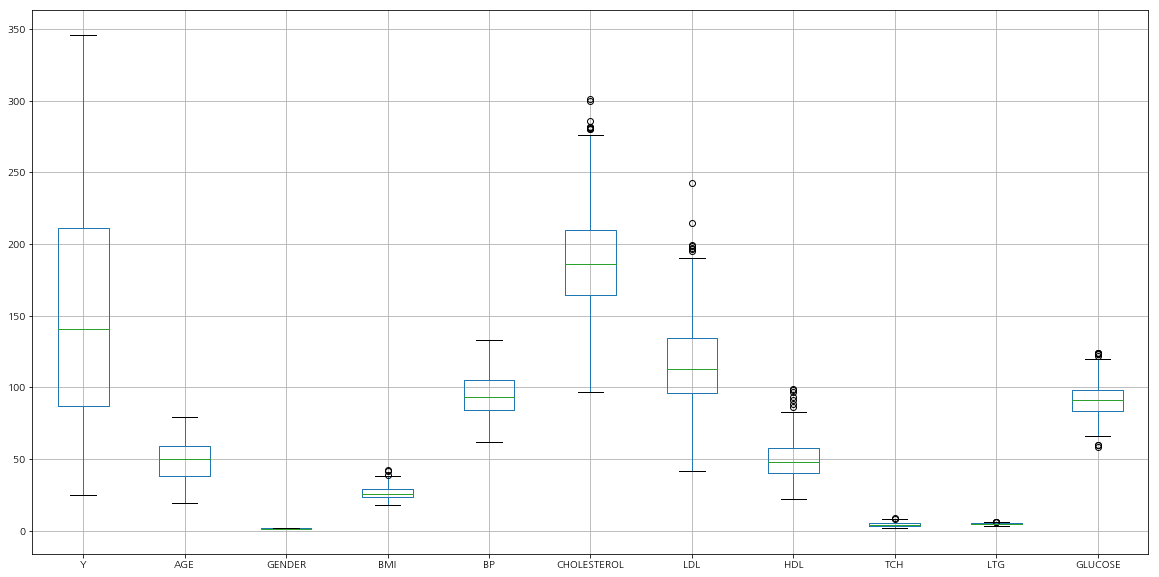

In [19]:
df_raw.boxplot(figsize=(20,10))

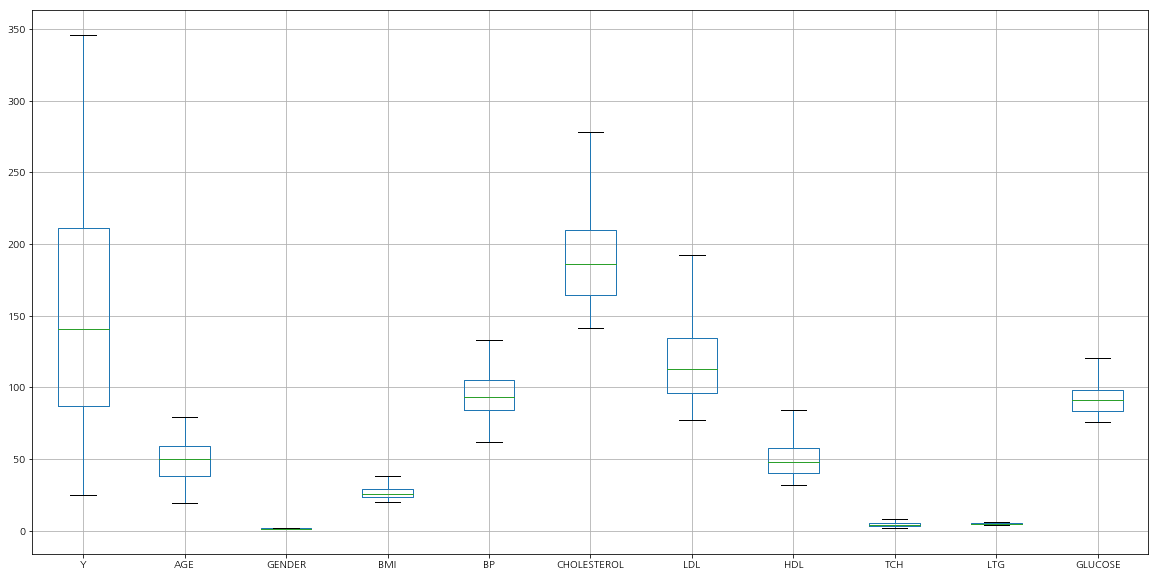

In [23]:
for x in df_raw.columns:
   if x != 'Y' and x != 'AGE' and x != 'GENDER' and x != 'BP' :
       a = np.percentile(df_raw[x],[25,75])
       l = a[1] + 1.5*(a[1]-a[0])
       u = a[1] - 1.5*(a[1]-a[0])
    
       df_raw[x][df_raw[x]>l] = l
       df_raw[x][df_raw[x]<u] = u 
        
df_raw.boxplot(figsize=(20,10))

In [24]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["Y"]
df_raw_x = df_raw.drop("Y", axis= 1, inplace = False)

In [25]:
# train_set_split(x:설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y= train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(309, 10)
train data Y size:(309,)
test data X size:(133, 10)
test data Y size:(133,)


In [26]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: -0.181


In [47]:
#parameter 값 출력
tree_uncustomized

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [48]:
train_score=[]; test_score=[]
para_leaf=[n_leaf * 1 for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

## for 문 띄어쓰기 주의!!

In [49]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,-0.181
1,2,0.953,-0.098
2,3,0.878,0.039
3,4,0.836,0.083
4,5,0.773,0.062
5,6,0.730,0.042
6,7,0.707,0.107
7,8,0.669,0.109
8,9,0.649,0.144
9,10,0.614,0.203


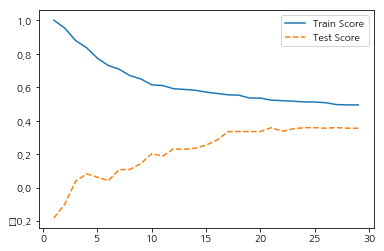

In [50]:
plt.plot(para_leaf,train_score,linestyle="-", label = "Train Score")
plt.plot(para_leaf,test_score,linestyle="--", label = "Test Score")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 node 선정

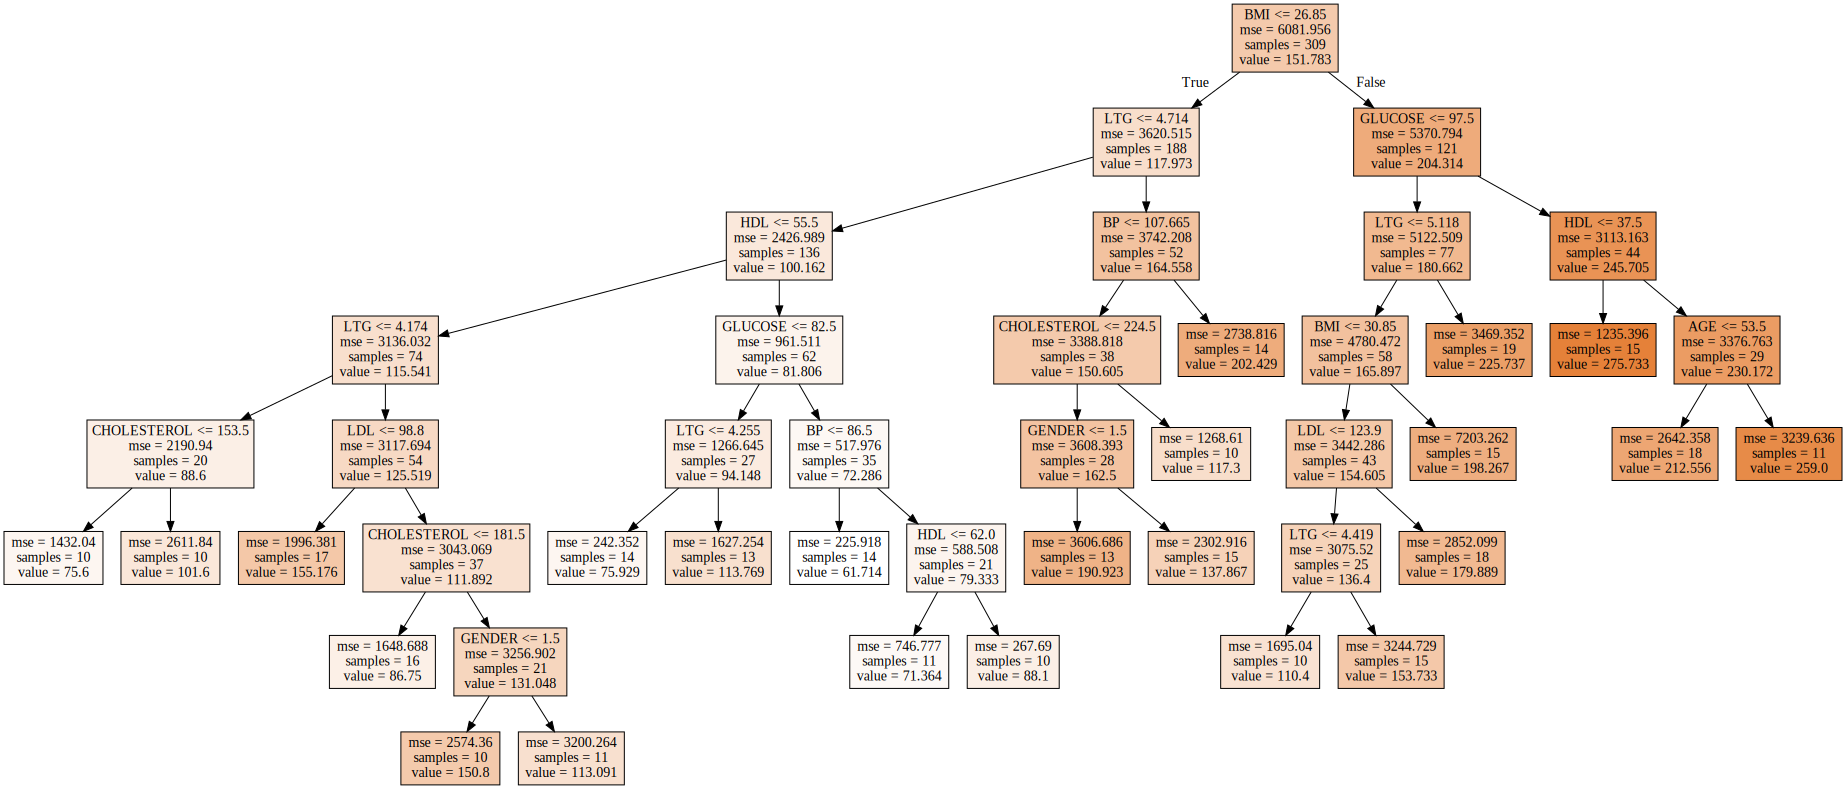

In [51]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=10)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

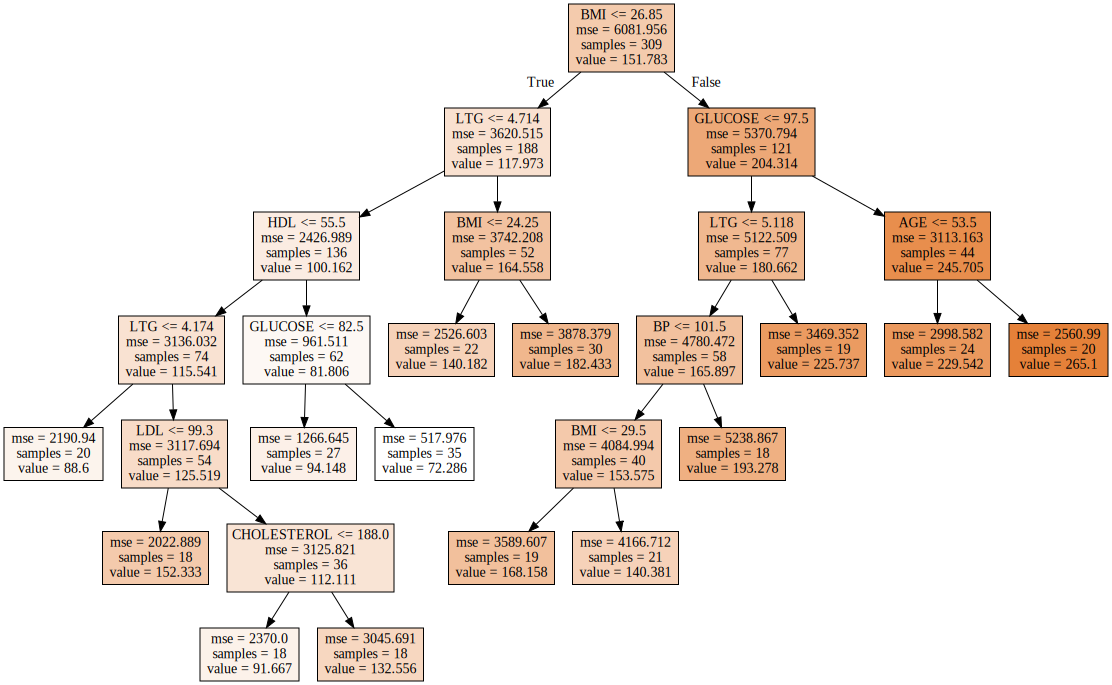

In [52]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=18)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

In [55]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(18,40)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=18, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,36,0.552,0.336
1,38,0.544,0.331
2,40,0.544,0.331
3,42,0.540,0.334
4,44,0.540,0.334
5,46,0.533,0.329
6,48,0.533,0.329
7,50,0.533,0.329
8,52,0.533,0.329
9,54,0.521,0.306


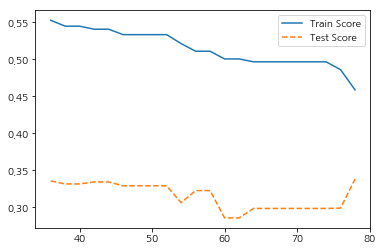

In [56]:
plt.plot(para_split,train_score,linestyle="-", label = "Train Score")
plt.plot(para_split,test_score,linestyle="--", label = "Test Score")
plt.legend()

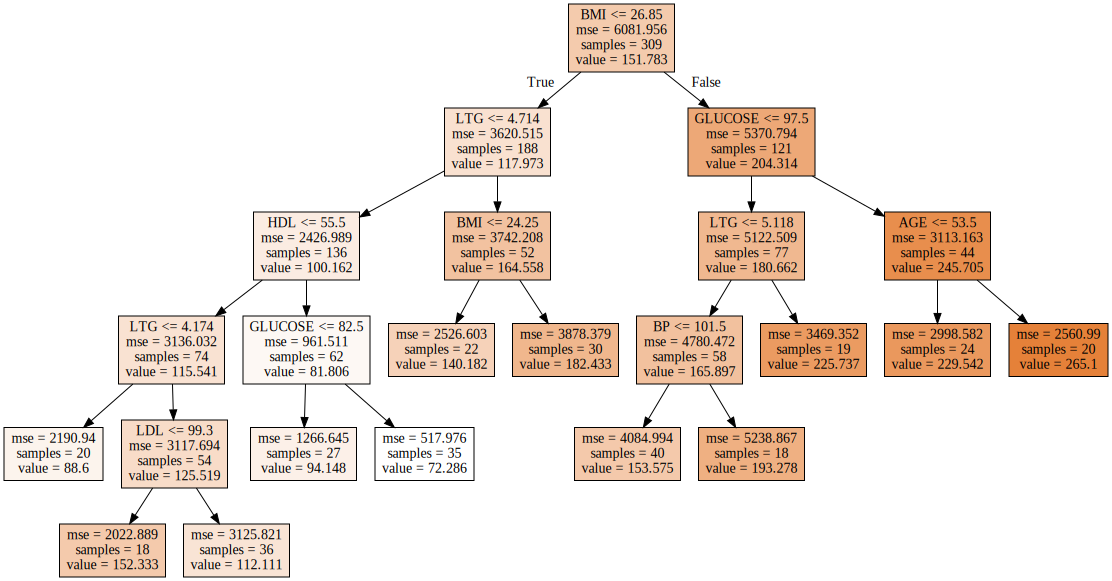

In [57]:
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 18, min_samples_split = 42)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [58]:
# 

train_score = []; test_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(4,11)]

for v_max_depth in para_depth :
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 18, min_samples_split = 42, max_depth = v_max_depth )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,4,0.53,0.351
1,5,0.54,0.334
2,6,0.54,0.334
3,7,0.54,0.334
4,8,0.54,0.334
5,9,0.54,0.334
6,10,0.54,0.334


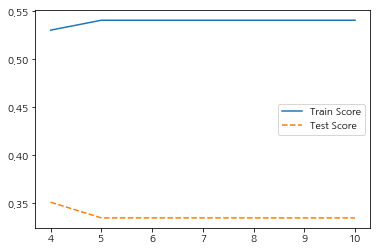

In [59]:
# 최대 깊이 증가에 따라 모델의 설명력은 증가
# Train/test 데이터의 성능 변화를 고려하여 4 선택
plt.plot(para_depth,train_score,linestyle="-", label = "Train Score")
plt.plot(para_depth,test_score,linestyle="--", label = "Test Score")
plt.legend()

위에서 leaf node = 8 / split node = 20 / depth = 5가 나왔지만, 최적은 아니다!!!

In [60]:
# p. 174

tree_final = DecisionTreeRegressor(min_samples_leaf=18, min_samples_split=42, max_depth = 4, random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=18,
           min_samples_split=42, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

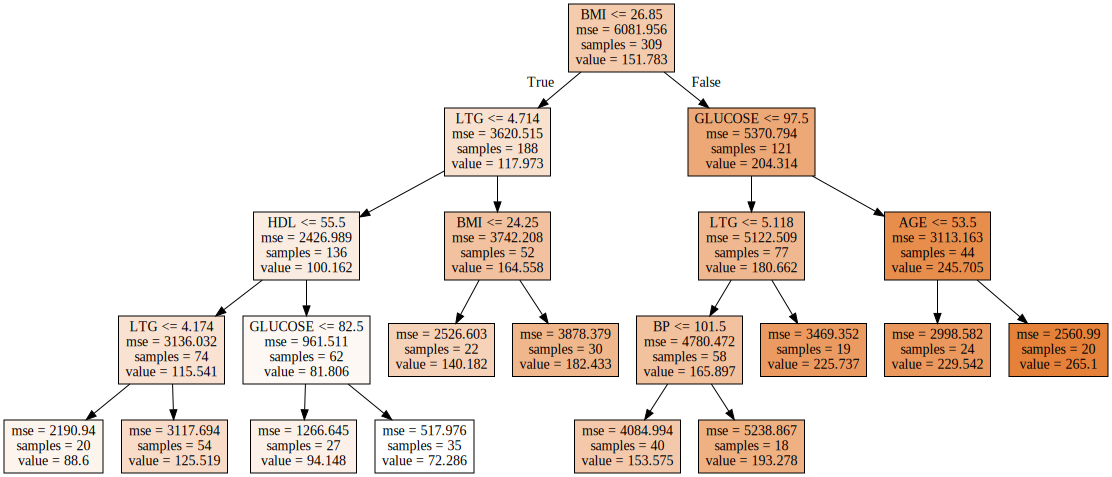

In [61]:
export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [62]:
train_score_final=[]; test_score_final=[]

train_score_final.append(tree.score(df_train_x, df_train_y))
test_score_final.append(tree.score(df_test_x, df_test_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [18]
df_score_final["TrainScore"]=train_score_final
df_score_final["TestScore"]=test_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,18,0.54,0.334


In [63]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_final.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.574
8,LTG,0.228
9,GLUCOSE,0.126
6,HDL,0.039
3,BP,0.020
0,AGE,0.014
1,GENDER,0.000
4,CHOLESTEROL,0.000
5,LDL,0.000
7,TCH,0.000


Text(0, 0.5, '변수')

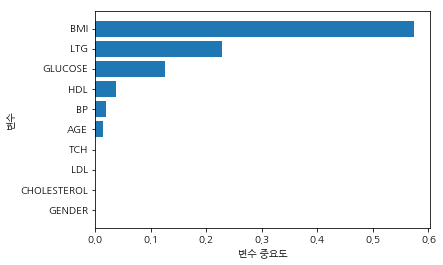

In [64]:
df_importance.sort_values("Importance",ascending = True, inplace = True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [65]:
# p. 178
estimator = DecisionTreeRegressor()

param_grid = {"criterion":["mse", "friedman_mse","mae"],"max_features":["auto","sqrt","log2"], "max_depth":para_depth,"min_samples_split":para_split, "min_samples_leaf":para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\best score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(criterion='mae', max_depth=9, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=54, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

best parameter: 
{'criterion': 'mae', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 54}
est score: 
0.394


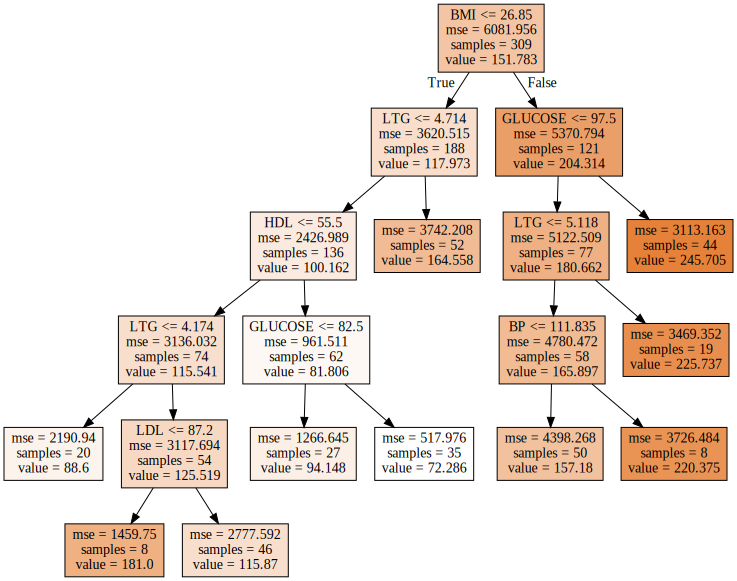

In [67]:
tree_final = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split= 54, max_depth = 9, random_state=1234)
tree_final.fit(df_train_x,df_train_y)
export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [68]:
train_score_final=[]; test_score_final=[]

train_score_final.append(tree_final.score(df_train_x, df_train_y))
test_score_final.append(tree_final.score(df_test_x, df_test_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [54]
df_score_final["TrainScore"]=train_score_final
df_score_final["TestScore"]=test_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,54,0.53,0.288
